In [1]:
#load the Basic libraries
import pandas as pd
import numpy as np
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as tsa_plots
from matplotlib.patches import Rectangle
%matplotlib inline

In [3]:
# Load Time series Libraries
import itertools
import statsmodels.formula.api as smf 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:
raw_data = pd.read_excel('Airlines+Data.xlsx')
raw_data.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [5]:
data = raw_data.copy()

In [6]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


No Null values. Note data type of data columns.

In [7]:
data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


##### Visualizing the data

In [8]:
viz = pd.read_excel('Airlines+Data.xlsx', header = 0, index_col = 0, parse_dates = True,squeeze=True)
viz

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2002-08-01    405
2002-09-01    355
2002-10-01    306
2002-11-01    271
2002-12-01    306
Name: Passengers, Length: 96, dtype: int64

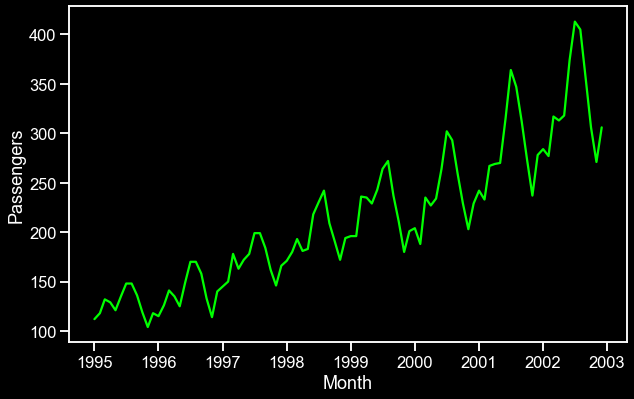

In [9]:
#Line plot
sns.set(rc = {'figure.figsize':(10, 6.18)})
sns.set(style = "ticks", context = "talk")
plt.style.use("dark_background")
sns.lineplot(data = viz, color = 'lime')
plt.show()

There seems to be a quadratic upward tend with multiplicative seasonality.

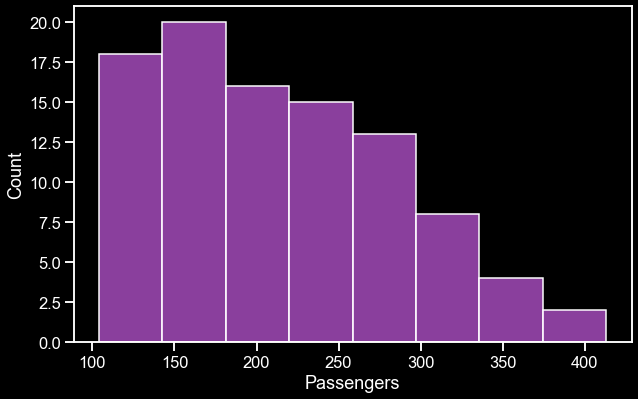

In [10]:
# Passenger count with reference to months
sns.histplot(data = viz, color = 'mediumorchid')
plt.show()

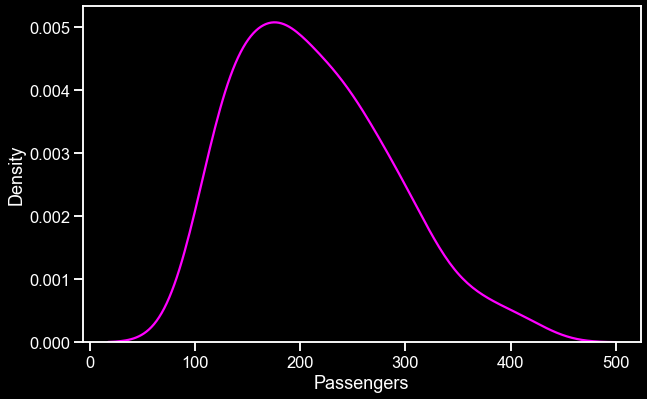

In [11]:
# Density Plot
sns.kdeplot(data = viz, color = 'fuchsia')
plt.show()

In [12]:
data["month"] = data.Month.dt.strftime("%b") # month extraction
data["year"] = data.Month.dt.strftime("%Y") # year extraction

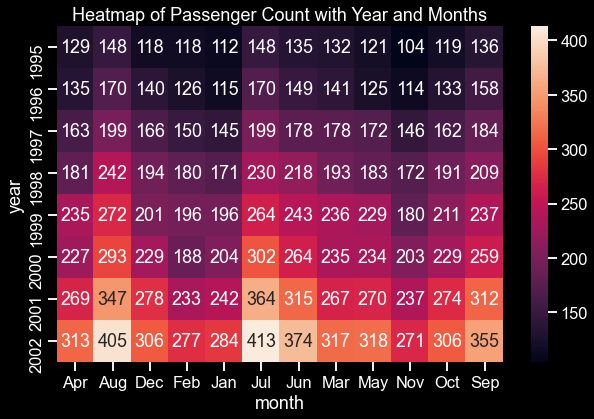

In [13]:
heatmap_y_month = pd.pivot_table(data = data, values = "Passengers", index = "year", 
                                 columns = "month", aggfunc = "mean", fill_value = 0)
sns.heatmap(heatmap_y_month, annot = True, fmt = "g");
plt.title('Heatmap of Passenger Count with Year and Months');

In [14]:
group = viz.groupby(pd.Grouper(freq = 'A'))
group.sum()

Month
1995-12-31    1520
1996-12-31    1676
1997-12-31    2042
1998-12-31    2364
1999-12-31    2700
2000-12-31    2867
2001-12-31    3408
2002-12-31    3939
Freq: A-DEC, Name: Passengers, dtype: int64

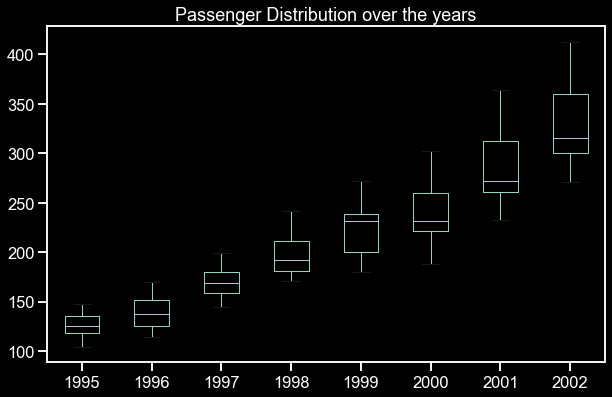

In [15]:
years = pd.DataFrame()
for i,j in group:
    years[i.year] = j.values
years.boxplot(grid = False)
plt.title('Passenger Distribution over the years')
plt.show()

##### Seasonal Decompose plots

In [16]:
decompose_ts = seasonal_decompose(viz,period = 12)

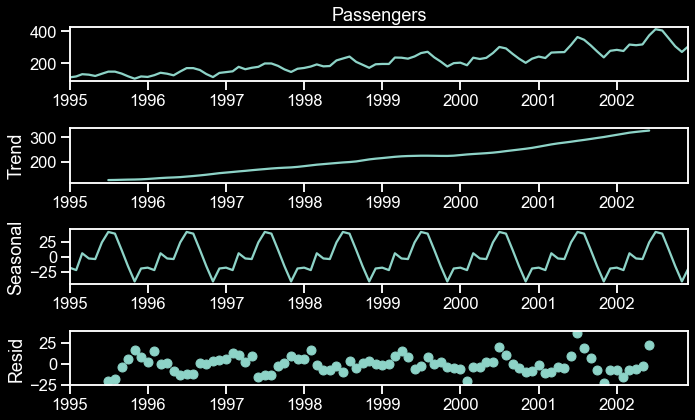

In [17]:
decompose_ts.plot()
plt.show() # plt.show() should be added otherwise 2 sets of graphs will be printed.

##### ACF and PACF plots

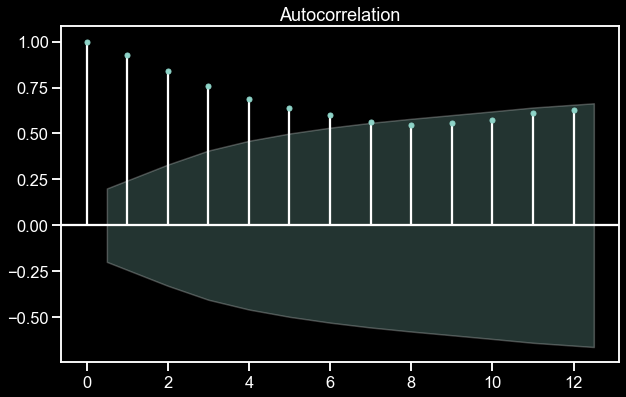

In [18]:
tsa_plots.plot_acf(viz, lags = 12) 
plt.show()

Autocorrelation Factor >> uptill 6 we have good corr() above +-2 SE.

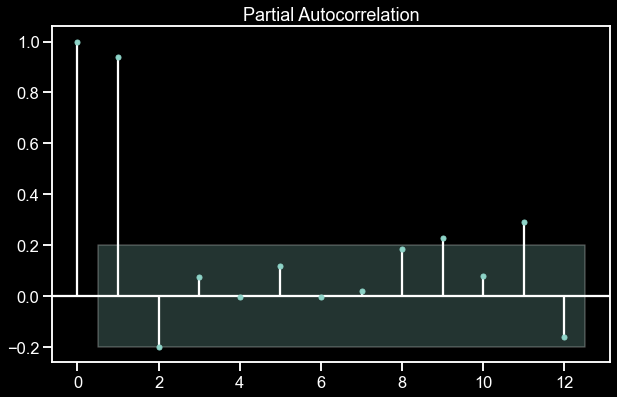

In [19]:
tsa_plots.plot_pacf(viz,lags=12) 
plt.show()

Partial Autocorrelation Factor: only 9 and 11 show some good corr() +-2 SE.

## Preprocess data

#### Transformations

In [20]:
# adding t values >> new variable 1
data['t'] = np.arange(1, data.shape[0] + 1) 

In [21]:
# adding t_sqr values >> new variable 2
data['t_sqr'] = data['t'] ** 2

In [22]:
# adding log_ values >> new variable 3
data['log_psgr'] = np.log(data['Passengers'])

In [23]:
#Generating dummies for months
month_dummies = pd.DataFrame(pd.get_dummies(data['month']))
data = pd.concat([data, month_dummies], axis = 1)

In [24]:
data.head()

,Month,Passengers,month,year,t,t_sqr,log_psgr,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


#### Partition & Metrics

In [25]:
#Partition Series
train = data.iloc[:84]
test = data.iloc[84:]

##### RMSE for Predictive Accuracy
- Model with lowest RMSE is the best

In [26]:
#performance metrics 
pfm_model_bsd = dict() # For model driven
pfm_data_bsd = dict() # For Data driven

## Applying Forecasting Methods
### Model Driven

#### Classical ML Model based Methods

In [27]:
#Linear Model
linear_model = smf.ols('Passengers~t', data = train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = mean_squared_error(test.Passengers, pred_linear, squared = False)
pfm_model_bsd.update( {'Linear Model' : rmse_linear} )
rmse_linear

53.19923653480271

In [28]:
#Exponential
Exp = smf.ols('log_psgr~t', data = train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = mean_squared_error(test.Passengers, pred_Exp, squared = False)
pfm_model_bsd.update( {'Exponential Model' : rmse_Exp} )
rmse_Exp

325.71506135515364

In [29]:
#Quadratic 
Quad = smf.ols('Passengers~t+t_sqr', data = train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t", "t_sqr"]]))
rmse_Quad = mean_squared_error(test.Passengers, pred_Quad, squared = False)
pfm_model_bsd.update( {'Quadratic Model' : rmse_Quad} )
rmse_Quad

48.05188897933093

In [30]:
#Additive seasonality 
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data = train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                                               'Aug', 'Sep', 'Oct', 'Nov']]))
rmse_add_sea = mean_squared_error(test.Passengers, pred_add_sea, squared = False)
pfm_model_bsd.update( {'Additive seasonality' : rmse_add_sea} )
rmse_add_sea

132.81978481421817

In [31]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols('Passengers~t+t_sqr+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', 
                       data = train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 't', 't_sqr']]))
rmse_add_sea_quad = mean_squared_error(test.Passengers, pred_add_sea_quad, squared = False)
pfm_model_bsd.update( {'Additive Seasonality Quadratic' : rmse_add_sea_quad} )
rmse_add_sea_quad

26.36081761209355

In [32]:
#Multiplicative Seasonality
Mul_sea = smf.ols('log_psgr~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = mean_squared_error(test.Passengers, pred_Mult_sea, squared = False)
pfm_model_bsd.update( {'Multiplicative Seasonality' : rmse_Mult_sea} )
rmse_Mult_sea

326.2267987143024

In [33]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols('log_psgr~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov', data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = mean_squared_error(test.Passengers, pred_Mult_add_sea, squared = False)
pfm_model_bsd.update( {'Multiplicative Additive Seasonality ' : rmse_Mult_add_sea} )
rmse_Mult_add_sea 

325.6952488040335

In [34]:
result_model_bsd = pd.DataFrame(pfm_model_bsd.items(), columns = ['MODEL', 'RMSE'])
result_model_bsd.sort_values(by = ['RMSE'])

,MODEL,RMSE
4,Additive Seasonality Quadratic,26.360818
2,Quadratic Model,48.051889
0,Linear Model,53.199237
3,Additive seasonality,132.819785
6,Multiplicative Additive Seasonality,325.695249
1,Exponential Model,325.715061
5,Multiplicative Seasonality,326.226799


Additive Seasonality Quadratic has the best values.

###### Model Evaluation - Additive Seasonality Quadratic

In [35]:
data2 = data.copy()
data2.head()

,Month,Passengers,month,year,t,t_sqr,log_psgr,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


In [36]:
data2.columns.values

array(['Month', 'Passengers', 'month', 'year', 't', 't_sqr', 'log_psgr',
       'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], dtype=object)

In [37]:
data2.drop(['Month', 't_sqr', 'log_psgr',
       'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May',
       'Nov', 'Oct', 'Sep'], axis = 1, inplace = True)
data2 = data2[['t', 'year', 'month', 'Passengers']] 
data1 = data2.copy()
data3 = data2.copy()
data_fnl = data2.copy()
data2.head()

,t,year,month,Passengers
0,1,1995,Jan,112
1,2,1995,Feb,118
2,3,1995,Mar,132
3,4,1995,Apr,129
4,5,1995,May,121


In [38]:
data2["Predicted"] = pd.Series(add_sea_Quad.predict(data[['Jan','Feb','Mar','Apr','May','Jun',
                                                    'Jul','Aug','Sep','Oct','Nov','t','t_sqr']]))
data2.head()

,t,year,month,Passengers,Predicted
0,1,1995,Jan,112,100.121972
1,2,1995,Feb,118,100.427467
2,3,1995,Mar,132,127.161533
3,4,1995,Apr,129,120.467028
4,5,1995,May,121,119.201095


In [39]:
# add a date column in the dataset
data2['Date'] = pd.date_range(start = '1995-01-01', end = '2002-12-01', freq = 'MS')
data2.head()

,t,year,month,Passengers,Predicted,Date
0,1,1995,Jan,112,100.121972,1995-01-01
1,2,1995,Feb,118,100.427467,1995-02-01
2,3,1995,Mar,132,127.161533,1995-03-01
3,4,1995,Apr,129,120.467028,1995-04-01
4,5,1995,May,121,119.201095,1995-05-01


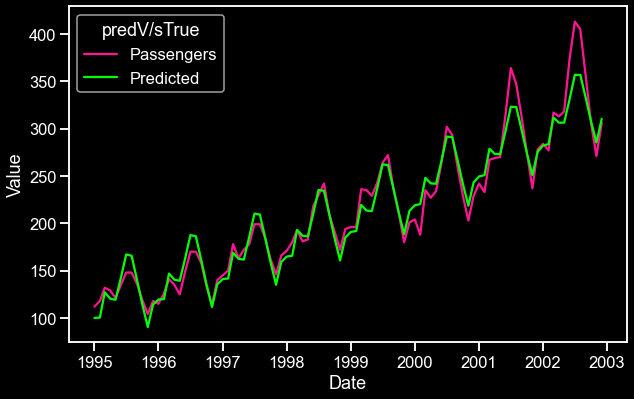

In [40]:
# line plot - View for the entire dataset _ ASQ
viz2 = data2.loc[:, ["Date", "Passengers", "Predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                              value_name = "Value")
sns.lineplot(data = viz2, x = viz2.Date, y = viz2.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

There is large variance.

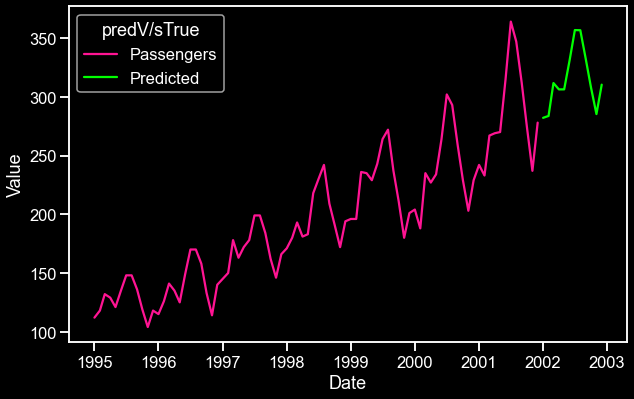

In [41]:
#Line plot - Train V/s Test Plot
data2.Predicted.iloc[:84] = np.nan
data2.Passengers.iloc[84:] = np.nan

viz3 = data2.loc[:, ["Date", "Passengers", "Predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                              value_name = "Value")
sns.lineplot(data = viz3, x = viz3.Date, y = viz3.Value ,hue = "predV/sTrue", 
             palette = ["deeppink","lime"]);

There is large variance from true value.

* PyCaret

In [42]:
data1.head()

,t,year,month,Passengers
0,1,1995,Jan,112
1,2,1995,Feb,118
2,3,1995,Mar,132
3,4,1995,Apr,129
4,5,1995,May,121


In [43]:
#Partition Series
train1 = data1.iloc[:84]
test1 = data1.iloc[84:]

In [44]:
# import the regression module
from pycaret.regression import *

s = setup(data = train1, test_data = test1, target = 'Passengers', 
          fold_strategy = 'timeseries', numeric_features = ['year', 't'], 
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Passengers
2,Original Data,"(84, 4)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(84, 14)"


In [45]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,13.6294,272.9848,16.4961,0.6555,0.0776,0.0652,0.0200
br,Bayesian Ridge,14.5454,324.4770,17.6463,0.5466,0.0888,0.0729,0.0167
lr,Linear Regression,14.5719,329.4924,17.7051,0.5344,0.0898,0.0735,3.5767
huber,Huber Regressor,17.1973,438.9776,20.4764,0.3967,0.1040,0.0863,0.0367
omp,Orthogonal Matching Pursuit,24.1095,872.4655,28.4732,0.1070,0.1280,0.1108,0.0233
en,Elastic Net,23.4992,884.3336,28.8580,0.0858,0.1289,0.1056,0.0200
lasso,Lasso Regression,24.4109,957.0820,30.4079,-0.0238,0.1366,0.1092,1.9733
dt,Decision Tree Regressor,27.4762,1288.0794,34.1757,-0.2275,0.1568,0.1233,0.0200
gbr,Gradient Boosting Regressor,30.2016,1543.3668,35.1711,-0.2883,0.1572,0.1289,0.0333
rf,Random Forest Regressor,32.4144,1832.4683,39.3174,-0.5742,0.1733,0.1346,0.1700


Best Values for Ridge Regression RMSE = 16.4864.

In [46]:
prediction_holdout = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,11.6495,233.6704,15.2863,0.8887,0.0415,0.0330


In [47]:
# generate predictions on the original dataset
predictions = predict_model(best, data = data1)
predictions.head()

,t,year,month,Passengers,Label
0,1,1995,Jan,112,110.110207
1,2,1995,Feb,118,111.733032
2,3,1995,Mar,132,127.183800
3,4,1995,Apr,129,123.364624
4,5,1995,May,121,122.471016


In [48]:
# add a date column in the dataset
predictions['Date'] = pd.date_range(start = '1995-01-01', end = '2002-12-01', freq = 'MS')
predictions.head()

,t,year,month,Passengers,Label,Date
0,1,1995,Jan,112,110.110207,1995-01-01
1,2,1995,Feb,118,111.733032,1995-02-01
2,3,1995,Mar,132,127.183800,1995-03-01
3,4,1995,Apr,129,123.364624,1995-04-01
4,5,1995,May,121,122.471016,1995-05-01


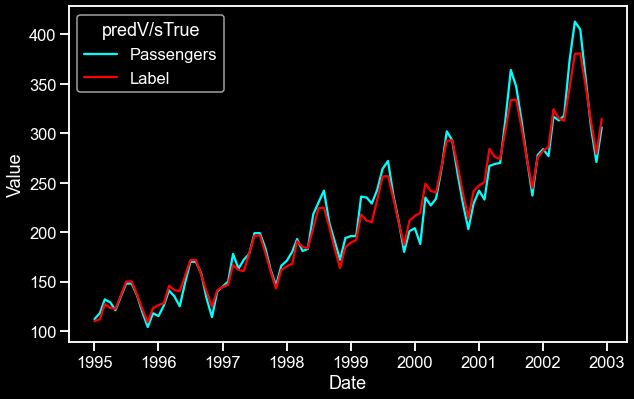

In [49]:
# line plot - View for the entire dataset

viz1 = predictions.loc[:, ["Date", "Passengers", "Label"]].melt("Date", var_name = "predV/sTrue", 
                                                                value_name = "Value")
sns.lineplot(data = viz1, x = viz1.Date, y = viz1.Value, hue = "predV/sTrue",palette=["aqua", "red"]);

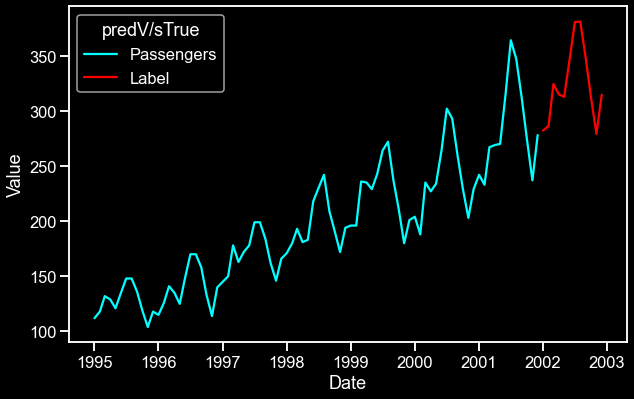

In [50]:
# line plot - View for Train vs test

predictions.Label.iloc[:84] = np.nan
predictions.Passengers.iloc[84:] = np.nan

viz4 = predictions.loc[:,["Date", "Passengers", "Label"]].melt("Date", var_name = "predV/sTrue", 
                                                               value_name = "Value")
sns.lineplot(data = viz4, x = viz4.Date, y = viz4.Value, hue = "predV/sTrue",palette =["aqua","red"]);

Lesser Variance compared to previous cases.

### Data Driven Forecasting Techniques

#### Moving Averages

In [51]:
#Make seperate dataset
data_ma = raw_data.copy()
data_ma = data_ma.set_index('Month')

#Simple Moving Average SMA
data_ma['3-month-SMA'] = data_ma['Passengers'].rolling(window = 3).mean()
data_ma['6-month-SMA'] = data_ma['Passengers'].rolling(window = 6).mean()
data_ma['12-month-SMA'] = data_ma['Passengers'].rolling(window = 12).mean()

data_ma.head()

,Passengers,3-month-SMA,6-month-SMA,12-month-SMA
Month,,,,
1995-01-01,112,NaN,NaN,NaN
1995-02-01,118,NaN,NaN,NaN
1995-03-01,132,120.666667,NaN,NaN
1995-04-01,129,126.333333,NaN,NaN
1995-05-01,121,127.333333,NaN,NaN


<AxesSubplot:xlabel='Month'>

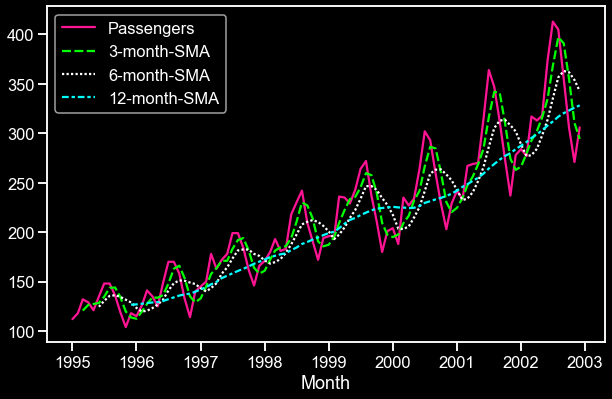

In [52]:
sns.lineplot(data = data_ma, palette = ["deeppink", "lime", "w", "aqua"]) #SMA Plot

In [53]:
#for 3-Months only since it will have the lowest SMA
data_ma['3-month-SMA'] = data_ma['3-month-SMA'].fillna(0)
rmse_SMA_3Months = mean_squared_error(data_ma.Passengers, data_ma['3-month-SMA'], squared = False)
pfm_data_bsd.update({'SMA-3Months':rmse_SMA_3Months}) 
rmse_SMA_3Months

25.172299774274222

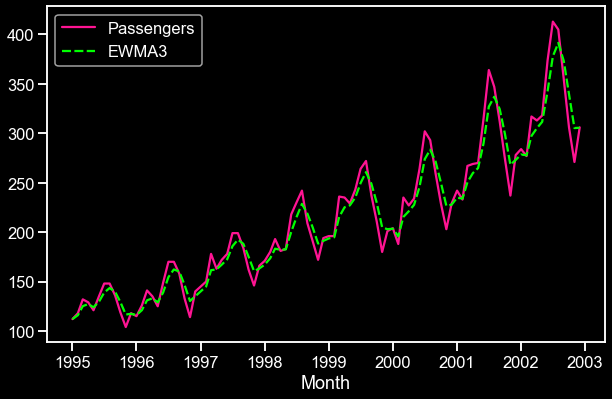

In [54]:
#Exponentially Weighted Moving Average EWMA
data_ma['EWMA3'] = data_ma['Passengers'].ewm(span = 3,adjust = True).mean() #3month Span

#Line Plot EWMA
sns.lineplot(data = data_ma[["Passengers", "EWMA3"]], palette = ["deeppink", "lime"]); #SMA Plot

In [55]:
#for 3-Months only since it will have the lowest EWMA
data_ma['EWMA3'] = data_ma['EWMA3'] .fillna(0)
rmse_EWMA3 = mean_squared_error(data_ma.Passengers, data_ma['EWMA3'] , squared = False)
pfm_data_bsd.update({'EWMA 3Months':rmse_EWMA3}) 
rmse_EWMA3 

13.973908389658527

#### Smoothing Techniques

In [56]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level = 0.2)
pred_ses = ses_model.predict(start = test.index[0], end = test.index[-1])
rmse_SES = mean_squared_error(test.Passengers, pred_ses, squared = False)
pfm_data_bsd.update({'SES':rmse_SES}) 
rmse_SES

64.84476396990497

In [57]:
# Holt method 
hw_model = Holt(train["Passengers"]).fit(smoothing_level = 0.8, smoothing_slope = 0.2)
pred_hw = hw_model.predict(start = test.index[0], end = test.index[-1])
rmse_Holt = mean_squared_error(test.Passengers, pred_hw, squared=False)
pfm_data_bsd.update({'Holt':rmse_Holt}) 
rmse_Holt

95.76674452675282

In [58]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Passengers"], seasonal = "add", trend = "add", 
                                         seasonal_periods = 12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0], end = test.index[-1])
rmse_hwe_add = mean_squared_error(test.Passengers, pred_hwe_add_add, squared = False)
pfm_data_bsd.update({'HWE Add. Seas & Add. Trend':rmse_hwe_add}) 
rmse_hwe_add

28.821803918224518

In [59]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"], seasonal = "mul", trend = "add", 
                                         seasonal_periods = 12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0], end = test.index[-1])
rmse_hwe_mul = mean_squared_error(test.Passengers, pred_hwe_mul_add, squared = False)
pfm_data_bsd.update({'HWE Mul. Seas & Add. Trend':rmse_hwe_mul}) 
rmse_hwe_mul                                              

12.920700425462794

In [60]:
pfm_data_bsd

{'SMA-3Months': 25.172299774274222,
 'EWMA 3Months': 13.973908389658527,
 'SES': 64.84476396990497,
 'Holt': 95.76674452675282,
 'HWE Add. Seas & Add. Trend': 28.821803918224518,
 'HWE Mul. Seas & Add. Trend': 12.920700425462794}

In [61]:
result_data_bsd = pd.DataFrame(pfm_data_bsd.items(), columns = ['MODEL', 'RMSE'])
result_data_bsd.sort_values(by = ['RMSE'])

,MODEL,RMSE
5,HWE Mul. Seas & Add. Trend,12.920700
1,EWMA 3Months,13.973908
0,SMA-3Months,25.172300
4,HWE Add. Seas & Add. Trend,28.821804
2,SES,64.844764
3,Holt,95.766745


Lowest RSME values are for HWE Multiplicative Seasonality and Additive Trend.

###### Model Evaluation - HWE Multiplicative Seasonality and Additive Trend

In [62]:
hwe_mul_model = hwe_model_mul_add.predict(start = data.index[0], end = data.index[-1])
data3['predicted'] = hwe_mul_model
data3.head()

,t,year,month,Passengers,predicted
0,1,1995,Jan,112,113.112975
1,2,1995,Feb,118,112.379635
2,3,1995,Mar,132,136.033355
3,4,1995,Apr,129,130.315239
4,5,1995,May,121,130.048758


In [63]:
# add a date column in the dataset
data3['Date'] = pd.date_range(start = '1995-01-01', end = '2002-12-01', freq = 'MS')
data3.head()

,t,year,month,Passengers,predicted,Date
0,1,1995,Jan,112,113.112975,1995-01-01
1,2,1995,Feb,118,112.379635,1995-02-01
2,3,1995,Mar,132,136.033355,1995-03-01
3,4,1995,Apr,129,130.315239,1995-04-01
4,5,1995,May,121,130.048758,1995-05-01


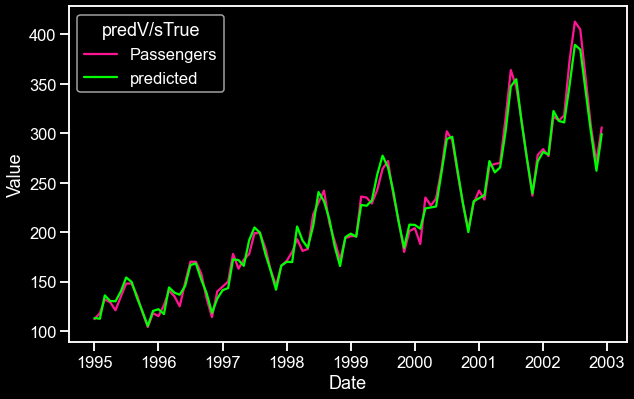

In [64]:
# line plot - View for the entire dataset _ ASQ
viz5 = data3.loc[:, ["Date", "Passengers", "predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                              value_name = "Value")
sns.lineplot(data = viz5, x = viz5.Date, y = viz5.Value, hue = "predV/sTrue", 
             palette = ["deeppink","lime"]);

Smallest Variance among all the models.

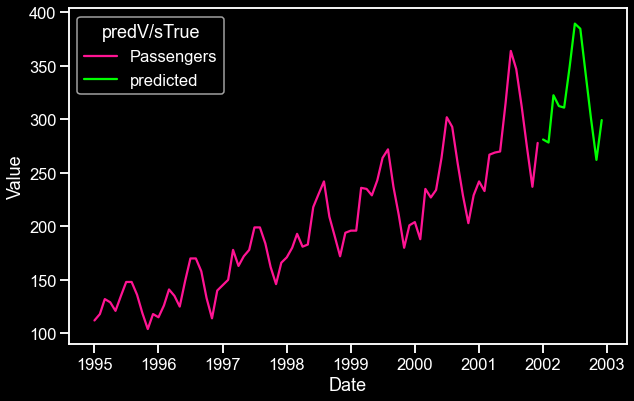

In [65]:
#Line plot - Train V/s Test Plot
data3.predicted.iloc[:84] = np.nan
data3.Passengers.iloc[84:] = np.nan

viz6 = data3.loc[:, ["Date", "Passengers", "predicted"]].melt("Date", var_name = "predV/sTrue", 
                                                              value_name = "Value")
sns.lineplot(data = viz6, x = viz6.Date, y = viz6.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

Best internal forecast so far.

##### AD-Fuller stationarity test

In [66]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index = labels)

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [67]:
data4 = raw_data.copy()
data4 = data4.set_index('Month')
data4.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [68]:
#AD- Fuller test
adf_test(data4) #As expected, data is non stationary
#We might need to use SARIMA test in this case

Fail to reject the null hypothesis
Data is non-stationary


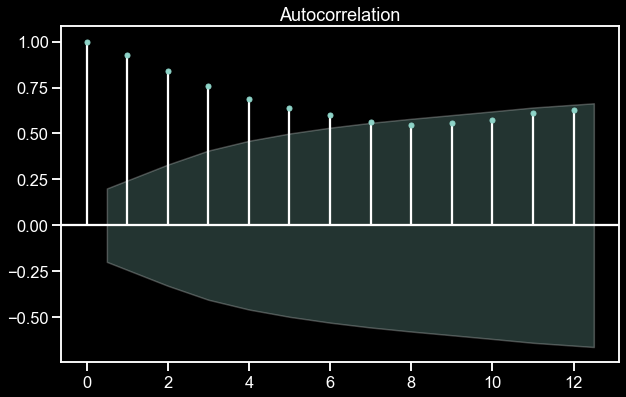

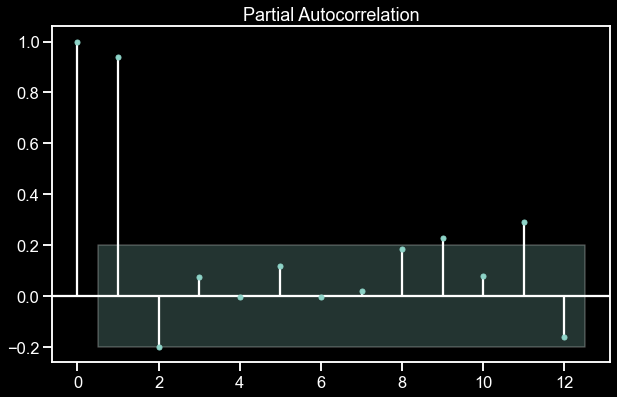

In [69]:
#ACF and PACF Plots
tsa_plots.plot_acf(viz, lags = 12) 
#Autocorrelation Factor >> uptill 6 we have good corr() above +-2 SE [Standard Error]
tsa_plots.plot_pacf(viz, lags = 12) 
#Partial Autocorrelation Factor >> only 9 and 11 show some good corr() +-2 SE [Standard Error]
plt.show()

In [70]:
from pmdarima import auto_arima # for determining ARIMA orders

In [71]:
stepwise_fit = auto_arima(data4.Passengers, start_p = 0, start_q = 0,
                          max_p = 12, max_q = 12, m = 12,
                          seasonal = False,
                          d = None, trace = True,
                          error_action = 'ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=871.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=867.283, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=863.757, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=870.076, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=862.193, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=861.773, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=860.702, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=862.251, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=855.919, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=860.821, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=856.719, Time=0.13 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -421.170
Date:                Sun, 11 Jul 2021   AIC                            854.341
Time:                        18:02:55   BIC                            869.664
Sample:                             0   HQIC                           860.533
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.142      1.071      0.284      -0.127       0.432
ar.L2          0.4062      0.144      2.815      0.005       0.123       0.689
ar.L3         -0.3167      0.121     -2.619      0.009      -0.554      -0.080
ma.L1          0.1470      0.121      1.215      0.224      -0.090       0.384
ma.L2         -0.7809      0.116     -6.734      0.000      -1.008      -0.554
sigma2       409.9286     75.390      5.437      0.000     262.167     557.690
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.41   Prob(JB):                         0.14
Heteroskedasticity (H):               3.63   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
#Fitting a model
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(train['Passengers'], order = (3, 1, 2))
results = model_arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                   83
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -358.852
Method:                       css-mle   S.D. of innovations             17.563
Date:                Sun, 11 Jul 2021   AIC                            731.704
Time:                        18:02:55   BIC                            748.636
Sample:                             1   HQIC                           738.506
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2519      2.130      1.057      0.290      -1.923       6.427
ar.L1.D.Passengers     0.9960      0.119      8.372      0.000       0.763       1.229
ar.L2.D.Passengers    -0.9938      0.123     -8.109      0.000      -1.234      -0.754
ar.L3.D.Passengers     0.0036      0.120      0.030      0.976      -0.232       0.239
ma.L1.D.Passengers    -0.9038      0.050    -18.162      0.000      -1.001      -0.806
ma.L2.D.Passengers     1.0000      0.057     17.571      0.000       0.888       1.112
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5011           -0.8711j            1.0049           -0.1669
AR.2            0.5011           +0.8711j            1.0049            0.1669
AR.3          272.6135           -0.0000j          272.6135           -0.0000
MA.1            0.4519           -0.8921j            1.0000           -0.1754
MA.2            0.4519           +0.8921j            1.0000            0.1754
-----------------------------------------------------------------------------
"""

In [73]:
pred_arima = results.predict(start = 84, end = len(data4) - 1, dynamic = False, typ = 'levels')

In [74]:
#RMSE score of ARIMA
rmse_arima = mean_squared_error(test.Passengers, pred_arima, squared = False)
rmse_arima

46.702728255208875

This value is quite high and we will not use it for forecasting.

## Evaluate and Compare Performance
- Best model we have got so far is the HWE Multiplicative Seasonality and Additive Trend
- We will build our final model based on this one

## Final Model

In [75]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
final_model = ExponentialSmoothing(data_fnl["Passengers"], seasonal = "mul", trend = "add", 
                                   seasonal_periods = 12).fit() 
pred_final = final_model.predict(start = data.index[0], end = data.index[-1])

#Getting RMSE Score
rmse_final = mean_squared_error(data.Passengers, pred_final, squared = False)
rmse_final

6.787458375228204

This score is excellent.

In [76]:
data_fnl.head()

,t,year,month,Passengers
0,1,1995,Jan,112
1,2,1995,Feb,118
2,3,1995,Mar,132
3,4,1995,Apr,129
4,5,1995,May,121


In [77]:
data_fnl['final_pred'] = pred_final
data_fnl.head()

,t,year,month,Passengers,final_pred
0,1,1995,Jan,112,113.175254
1,2,1995,Feb,118,111.886528
2,3,1995,Mar,132,135.733126
3,4,1995,Apr,129,130.698554
4,5,1995,May,121,130.785842


In [78]:
data_fnl['Date'] = pd.date_range(start = '1995-01-01', end = '2002-12-01', freq = 'MS')
data_fnl.head()

,t,year,month,Passengers,final_pred,Date
0,1,1995,Jan,112,113.175254,1995-01-01
1,2,1995,Feb,118,111.886528,1995-02-01
2,3,1995,Mar,132,135.733126,1995-03-01
3,4,1995,Apr,129,130.698554,1995-04-01
4,5,1995,May,121,130.785842,1995-05-01


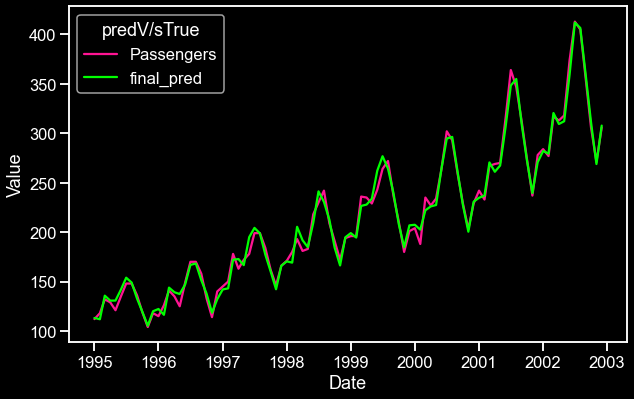

In [79]:
# line plot - View for the entire dataset FInal Model
viz8 = data_fnl.loc[:, ["Date", "Passengers", "final_pred"]].melt("Date", var_name = "predV/sTrue", 
                                                                  value_name = "Value")
sns.lineplot(data = viz8, x = viz8.Date, y = viz8.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

Best model

In [80]:
#Forecasting the future
future = pd.DataFrame(final_model.forecast(24)).reset_index()
future.rename(columns = {'index':'t', 0:'Forecast'},inplace = True)
future.head()

,t,Forecast
0,96,312.899768
1,97,308.171843
2,98,355.533483
3,99,345.770653
4,100,345.697050


In [81]:
#Creating Forecast dataset
forecast_df= pd.concat([data_fnl, future], axis = 0)
forecast_df.drop('Date', axis = 1)
forecast_df['Date'] = pd.date_range(start = '1995-01-01', end = '2004-12-01', freq = 'MS')
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 23
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   t           120 non-null    int64         
 1   year        96 non-null     object        
 2   month       96 non-null     object        
 3   Passengers  96 non-null     float64       
 4   final_pred  96 non-null     float64       
 5   Date        120 non-null    datetime64[ns]
 6   Forecast    24 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 7.5+ KB


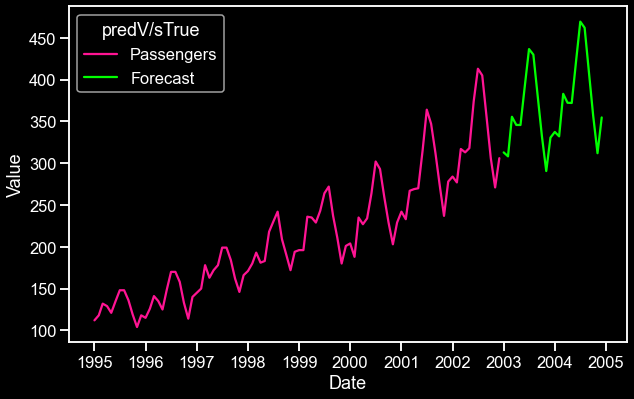

In [82]:
#Future Forecast

viz9 = forecast_df.loc[:, ["Date","Passengers","Forecast"]].melt("Date", var_name = "predV/sTrue", 
                                                                 value_name = "Value")
sns.lineplot(data = viz9, x = viz9.Date, y = viz9.Value, hue = "predV/sTrue", 
             palette = ["deeppink", "lime"]);

Best internal forecast.